# Assignment 4

In [7]:
# my library 
# pip install mjzy
# pip install mjzy==0.3.9
from mjzy import covarience_matrix,portfolio,simulation,Var,MLE

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
import scipy.stats as st
from scipy.optimize import minimize 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Problem1
Use the data in problem1.csv.  Fit a Normal Distribution and a Generalized T distribution to this data. 
Calculate the VaR and ES for both fitted distributions

In [3]:
data = pd.read_csv('problem1.csv')
print(data)

            x
0   -0.002665
1   -0.045128
2    0.053635
3    0.010450
4   -0.016284
..        ...
495  0.009279
496 -0.001121
497  0.075188
498  0.038520
499 -0.033949

[500 rows x 1 columns]


In [17]:

def cal_VaR_ES_normal(data, nSim=10000, alpha=0.05):

    mu = data.mean().values
    sigma = np.std(data).values
    simu_return = np.random.normal(mu, sigma, nSim)
    simu_return.sort()

    # Calculate the index of the value at risk at the confidence level alpha
    n = int(alpha * len(simu_return))

    # Calculate the indices of the upper and lower values at risk
    iup = int(np.ceil(n))
    idn = int(np.floor(n))

    # Calculate the Value at Risk (VaR) as the average of the upper and lower values
    VaR = -(simu_return[iup] + simu_return[idn])/2

    # Calculate the Expected Shortfall (ES) as the average of all returns below the lower value at risk
    ES = -np.mean(simu_return[0:idn])

    return VaR, ES, simu_return


cal_VaR_ES_normal(data)


(0.08168081506578885,
 0.10162294787110752,
 array([-0.18695028, -0.1617794 , -0.1610811 , ...,  0.18990633,
         0.19323343,  0.20628997]))

In [19]:
# library function
normal_var,normal_es,normal_simu=Var.noramal_VaR_ES(data)

In [54]:
# MLE fitted T distribution
def cal_VaR_ES_T(data, alpha = 0.05,size=10000):

    t_df, t_m, t_s = st.t.fit(data)
    t = st.t.rvs(df = t_df, loc = t_m, scale = t_s, size=size)
    tsim = pd.DataFrame({"tsim": t})
    VaR_T = -st.t.ppf(alpha, df = t_df, loc = t_m, scale = t_s)
    temp = tsim[tsim <= -VaR_T].dropna()
    ES_T = -temp.mean().values
    return VaR_T, ES_T[0] ,t

cal_VaR_ES_T(data)


(0.07559610356471451,
 0.11145002383809925,
 array([ 0.00142757, -0.01165102,  0.06161981, ...,  0.02214431,
         0.04153204,  0.00017261]))

In [20]:
# library function
t_var,t_es,t_simu=Var.t_VaR_ES(data)

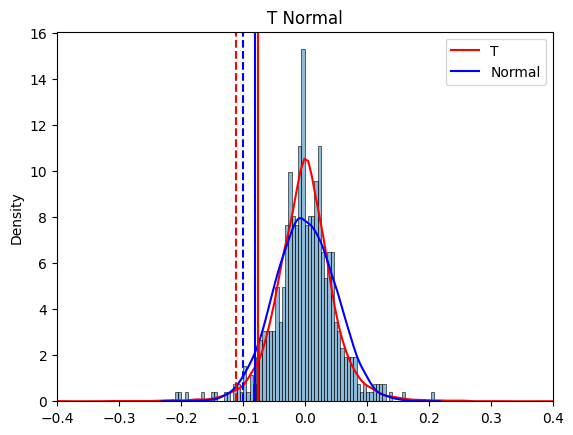

In [34]:
# plot
sns.histplot(data, bins=80,alpha=0.5,stat='density')
sns.kdeplot(t_simu,color="red",label="T")
sns.kdeplot(normal_simu,color="b",label="Normal")

plt.axvline(-t_es,color='red',linestyle='--')
plt.axvline(-t_var,color='red',linestyle='-')

plt.axvline(-normal_es,color='b',linestyle='--')
plt.axvline(-normal_var,color='b',linestyle='-')

plt.title('T Normal')

plt.xlim(-0.4, 0.4)
plt.legend()
plt.show()

### Problem2
In your main repository, create a Library for risk management.   Create modules, classes, packages, etc 
as you see fit.  Include all the functionality we have discussed so far in class.  Make sure it includes
1. Covariance estimation techniques.
2. Non PSD fixes for correlation matrices
3. Simulation Methods
4. VaR calculation methods (all discussed)
5. ES calculation
Create a test suite and show that each function performs as expected.

In [3]:
b = pd.read_csv("DailyPrices.csv")
returns = portfolio.return_calculate(b)
returns.drop('Date', axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mjzy/portfolio.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_da[col_new[i]] = price_return[:,i]


In [39]:
# build non-PSD
n = 500
non_PSD = np.full((n,n),0.9)
for i in range(n):
    non_PSD[i,i]=1.0
non_PSD[0,1] = 0.7357
non_PSD[1,0] = 0.7357
print(non_PSD)

[[1.     0.7357 0.9    ... 0.9    0.9    0.9   ]
 [0.7357 1.     0.9    ... 0.9    0.9    0.9   ]
 [0.9    0.9    1.     ... 0.9    0.9    0.9   ]
 ...
 [0.9    0.9    0.9    ... 1.     0.9    0.9   ]
 [0.9    0.9    0.9    ... 0.9    1.     0.9   ]
 [0.9    0.9    0.9    ... 0.9    0.9    1.    ]]


In [40]:
# check if functions fix non_psd

def check_psd(matrix):
    eigenvalues = np.linalg.eigh(matrix)[0]
    return np.all(eigenvalues >= -1e-8)

In [41]:
c = covarience_matrix.Higham_near_psd(non_PSD)
check_psd(c)

True

In [43]:
d = covarience_matrix.near_psd(non_PSD)
check_psd(d)

True

In [4]:
portfolio_data = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")


In [6]:
portfolio.cal_porfolio_price(portfolio_data,prices,portfolio_='A')

(array([299950.05907389]),
                Date        AAPL        TSLA         JPM          HD  \
 0    2/14/2022 0:00  167.863144  291.920013  147.619888  342.932312   
 1    2/15/2022 0:00  171.749573  307.476654  149.778656  344.590576   
 2    2/16/2022 0:00  171.511032  307.796661  150.049713  341.498352   
 3    2/17/2022 0:00  167.863144  292.116669  146.593735  339.401123   
 4    2/18/2022 0:00  166.292648  285.660004  147.281052  338.357391   
 ..              ...         ...         ...         ...         ...   
 244   2/3/2023 0:00  154.264465  189.979996  141.089996  331.500000   
 245   2/6/2023 0:00  151.498688  194.759995  141.919998  329.269989   
 246   2/7/2023 0:00  154.414230  196.809998  143.649994  325.200012   
 247   2/8/2023 0:00  151.688400  201.289993  142.639999  320.790008   
 248   2/9/2023 0:00  150.639999  207.320007  140.419998  315.549988   
 
            BAC         XOM        AVGO         PEP         TMO  ...  \
 0    46.340988   76.808563  560.55

In [44]:
Var.Delta_Normal_VaR(portfolio_data,prices,portfolio_='All')

(864378.48041924, 13577.077108381169)

In [45]:
portfolio.cal_porfolio_price(portfolio_data,prices,portfolio_="All")

(array([864378.48041924]),
                Date        AAPL        ABBV         ABT         ACN  \
 0    2/14/2022 0:00  167.863144  137.756256  120.633438  321.260742   
 1    2/15/2022 0:00  171.749573  139.451721  121.812462  324.491760   
 2    2/16/2022 0:00  171.511032  140.521042  121.517708  328.737427   
 3    2/17/2022 0:00  167.863144  139.654022  118.471909  318.088837   
 4    2/18/2022 0:00  166.292648  138.748505  114.748161  316.384644   
 ..              ...         ...         ...         ...         ...   
 244   2/3/2023 0:00  154.264465  145.199997  111.790001  289.220001   
 245   2/6/2023 0:00  151.498688  145.020004  110.750000  284.480011   
 246   2/7/2023 0:00  154.414230  145.139999  111.989998  287.820007   
 247   2/8/2023 0:00  151.688400  144.610001  110.199997  284.709992   
 248   2/9/2023 0:00  150.639999  148.699997  108.070000  285.160004   
 
            ADBE         ADI         ADP        AMAT         AMD  ...  \
 0    474.010010  151.118790  198.

In [31]:
portfolio.Norm_price(portfolio_data,prices)

(array([864378.48041924]),
                Date        AAPL        ABBV         ABT         ACN  \
 0    2/14/2022 0:00  167.863144  137.756256  120.633438  321.260742   
 1    2/15/2022 0:00  171.749573  139.451721  121.812462  324.491760   
 2    2/16/2022 0:00  171.511032  140.521042  121.517708  328.737427   
 3    2/17/2022 0:00  167.863144  139.654022  118.471909  318.088837   
 4    2/18/2022 0:00  166.292648  138.748505  114.748161  316.384644   
 ..              ...         ...         ...         ...         ...   
 244   2/3/2023 0:00  154.264465  145.199997  111.790001  289.220001   
 245   2/6/2023 0:00  151.498688  145.020004  110.750000  284.480011   
 246   2/7/2023 0:00  154.414230  145.139999  111.989998  287.820007   
 247   2/8/2023 0:00  151.688400  144.610001  110.199997  284.709992   
 248   2/9/2023 0:00  150.639999  148.699997  108.070000  285.160004   
 
            ADBE         ADI         ADP        AMAT         AMD  ...  \
 0    474.010010  151.118790  198.

In [46]:
Var.Delta_Normal_VaR(portfolio_data,prices,portfolio_='B')

(294385.59081765, 4494.598976956561)

In [47]:
Var.cal_historical(portfolio_data,prices,portfolio_='C')

(270042.8305277,
 5558.724403455835,
 7472.847422317922,
 array([-3176.42659672,  4267.0962076 , -2043.80606089, ...,
         2565.8864628 , -2684.00457213,  4466.49064126]))

In [48]:
Var.cal_monte_var(portfolio_data,prices,portfolio_='All')

(864378.48041924,
 13114.194780530268,
 16528.7485054694,
 array([ 8756.35263793,  8338.16697385, 14056.38395547, ...,
         6063.02091451,  2779.10354471,  7578.41680861]))

In [49]:
Var.cal_monte_var(portfolio_data,prices,portfolio_='A')

(299950.05907389,
 5534.604595804715,
 7046.281935372848,
 array([4806.59277892, 2346.53571767, 3031.34018233, ..., 5020.37678353,
         566.93544556, 1742.47551388]))

In [51]:
a=covarience_matrix.exp_weighted_cov(returns)
a

array([[1.55394452e-04, 2.09675264e-04, 2.34624899e-04, ...,
        2.09103386e-04, 1.60199185e-04, 6.30934049e-05],
       [2.09675264e-04, 4.20748823e-04, 3.20799332e-04, ...,
        2.86271602e-04, 2.01037391e-04, 6.38158300e-05],
       [2.34624899e-04, 3.20799332e-04, 4.99245299e-04, ...,
        2.96873952e-04, 1.92310525e-04, 3.84827190e-05],
       ...,
       [2.09103386e-04, 2.86271602e-04, 2.96873952e-04, ...,
        7.15582099e-04, 2.13164708e-04, 6.42681389e-05],
       [1.60199185e-04, 2.01037391e-04, 1.92310525e-04, ...,
        2.13164708e-04, 3.25325125e-04, 7.25508817e-05],
       [6.30934049e-05, 6.38158300e-05, 3.84827190e-05, ...,
        6.42681389e-05, 7.25508817e-05, 1.70524424e-04]])

In [52]:
simulation.multivariate_normal_simulation(a,500)

array([[-1.35591227e-02, -2.41758988e-02, -4.28753679e-02, ...,
         4.17078059e-03, -2.34925962e-02,  2.28673771e-02],
       [ 1.28033204e-02,  1.94995301e-02,  1.54929575e-02, ...,
         4.51957145e-03,  1.86448296e-02, -2.05724880e-02],
       [ 3.69827061e-02,  4.37409410e-02,  5.02338326e-02, ...,
         7.74276485e-02,  4.08274337e-02,  2.78714159e-02],
       ...,
       [-6.59282344e-03, -9.55307269e-03, -2.29657314e-02, ...,
         2.18072179e-02, -5.57316664e-03, -1.16606981e-02],
       [ 6.13378683e-03,  9.67359526e-03,  1.59233511e-02, ...,
        -1.16915921e-02,  2.49633131e-02,  5.12705155e-05],
       [ 3.49158493e-03, -1.76184867e-02,  1.42747907e-02, ...,
         3.23184052e-02,  1.63570470e-02,  1.66276271e-02]])

In [4]:
Var.ar1_var_es(data)

(0.07983992004680988,
 0.10066655405694472,
 array([-0.0030789 ,  0.00471974,  0.07212143, ..., -0.03461615,
         0.00391462, -0.05429513]))

In [62]:
Var.t_VaR_ES(data)

(0.07647602684516216,
 0.11097768054565885,
 array([-0.01482358,  0.01397264, -0.02118115, ...,  0.05362281,
         0.00820101,  0.05890264]))

In [59]:
Var.calculate_var_hist(data)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(0.07598069069686242,
 x    0.116777
 dtype: float64,
             x
 0   -0.002665
 1   -0.045128
 2    0.053635
 3    0.010450
 4   -0.016284
 ..        ...
 495  0.009279
 496 -0.001121
 497  0.075188
 498  0.038520
 499 -0.033949
 
 [500 rows x 1 columns])

In [5]:
Var.normal_weighted(data)

(0.08837552594248277,
 0.006156665945739791,
 array([ 0.02362946,  0.04123994, -0.10976854, ..., -0.01331471,
         0.01198346,  0.0809735 ]))

In [54]:
Var.calculate_var_hist(data)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(0.07598069069686242,
 x    0.116777
 dtype: float64,
             x
 0   -0.002665
 1   -0.045128
 2    0.053635
 3    0.010450
 4   -0.016284
 ..        ...
 495  0.009279
 496 -0.001121
 497  0.075188
 498  0.038520
 499 -0.033949
 
 [500 rows x 1 columns])

### Probelm3
Use your repository from #2.
Using Portfolio.csv and DailyPrices.csv.  Assume the expected return on all stocks is 0.
This file contains the stock holdings of 3 portfolios.  You own each of these portfolios.
Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your
total VaR and ES.  Compare the results from this to your VaR form Problem 3 from Week 4.

In [55]:
# get portfolio type
def get_type(portfolio_data):
    portfolio_type=[]
    portfolio_type.append("All")
    for po in portfolio_data["Portfolio"]:
        if po not in portfolio_type:
            portfolio_type.append(po)
    return portfolio_type

portfolio_type = get_type(portfolio_data)
portfolio_type

['All', 'A', 'B', 'C']

In [63]:
mean = 0
alpha = 0.05
num_simulations = 10000

In [66]:
def cal_po(portfolio_data,prices,pt):
    
    # PREPARE
    params = []
    ar_cdf = pd.DataFrame()
    sim_cdf = pd.DataFrame()
    sim_returns = pd.DataFrame()
    
    # GET PORFOLIO INFO
    p, ap, h = portfolio.cal_porfolio_price(portfolio_data, prices, pt)
    ar = portfolio.return_calculate(ap)
    ar.drop('Date', axis=1, inplace=True)
    nar = ar - ar.mean()
    for s in nar.columns.tolist():
        p = MLE.fit_t_distribution(nar[s])
        params.append(p)
        ar_cdf[s] = t.cdf(nar[s], df=p[0], loc=p[1], scale=p[2])
    np.random.seed(1)
    spearman_corr = ar_cdf.corr(method='spearman')
    simu = simulation.multivariate_normal_simulation(spearman_corr, num_simulations, method='pca')
    simu = pd.DataFrame(simu, columns=ar.columns)
    for s in simu.columns.tolist():
        sim_cdf[s] = norm.cdf(simu[s], loc=0, scale=1)
    for n, s in enumerate(simu.columns.tolist()):
        sim_returns[s] = t.ppf(sim_cdf[s], df=params[n][0], loc=params[n][1], scale=params[n][2])
    ap.drop('Date', axis=1, inplace=True)
    sim_prices = np.dot(sim_returns * ap.tail(1).values.reshape(ap.shape[1],), h)
    
    # calculate var and es
    var_t = mean - np.quantile(sim_prices, alpha)
    es_t = -np.mean(sim_prices[sim_prices <= -var_t])
    
    return var_t,es_t,sim_prices

Portfolio type All: VaR_T = 19820.96258156469, ES_T = 26273.29537620832


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


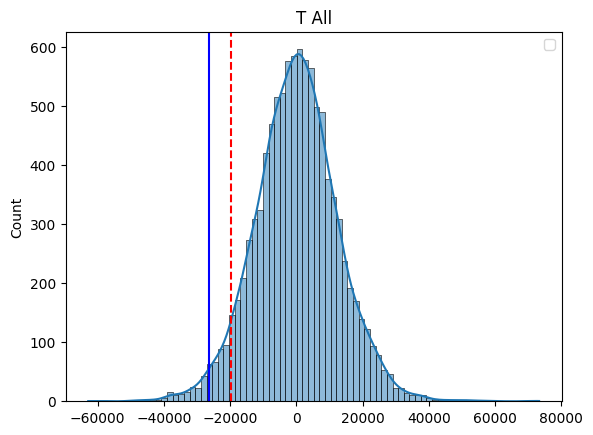

Portfolio type A: VaR_T = 7924.110067407117, ES_T = 10468.401212222092


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


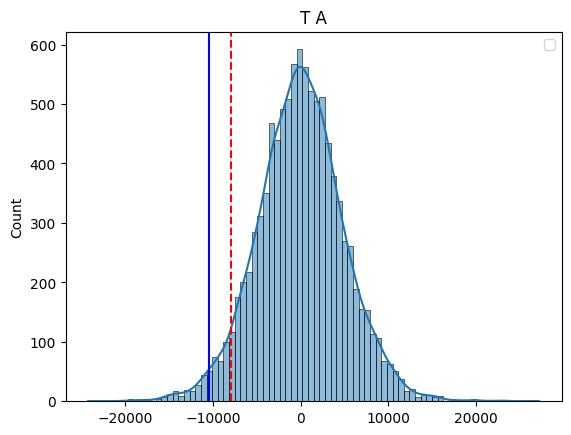

Portfolio type B: VaR_T = 6693.189181940957, ES_T = 8795.589522813323


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


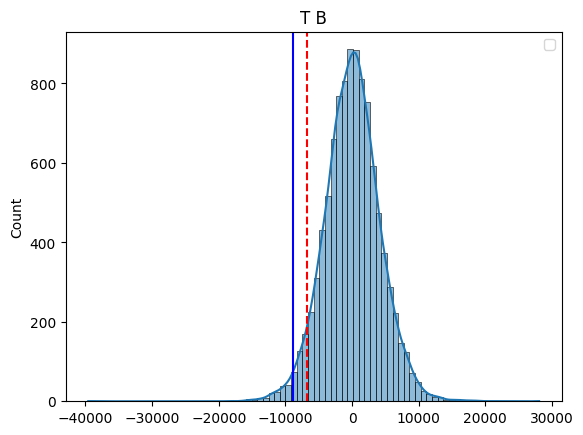

Portfolio type C: VaR_T = 5653.332593249789, ES_T = 7439.533033469491


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


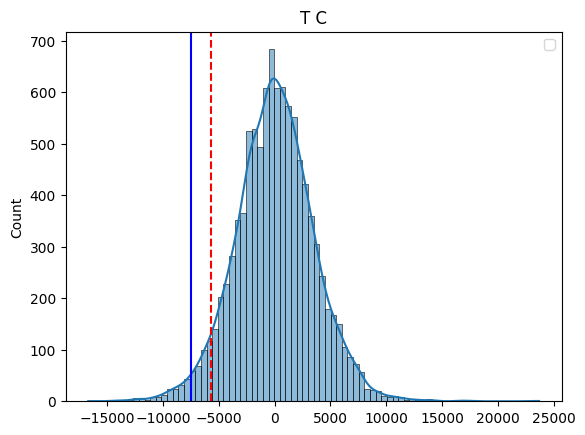

In [67]:
for pt in portfolio_type:
    var_t,es_t,sim_prices=cal_po(portfolio_data,prices,pt)
    # Print results
    print(f"Portfolio type {pt}: VaR_T = {var_t}, ES_T = {es_t}")
    # plot results
    sns.histplot(sim_prices, bins=80,alpha=0.5,kde=True)
    plt.axvline(-var_t,color='red',linestyle='--')
    plt.axvline(-es_t,color='b',linestyle='-')
    plt.title('T {}'.format(pt))

    plt.legend()
    plt.show()